In [2]:
from torch import nn
import torch


def unsorted_segment_sum(data, segment_ids, num_segments):
    """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`."""
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

def get_edges(n_nodes):
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                rows.append(i)
                cols.append(j)

    edges = [rows, cols]
    return edges


def get_edges_batch(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = torch.ones(len(edges[0]) * batch_size, 1)
    edges = [torch.LongTensor(edges[0]), torch.LongTensor(edges[1])]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [torch.cat(rows), torch.cat(cols)]
    return edges, edge_attr

In [3]:
class E_GCL(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, nodes_att_dim=0, act_fn=nn.ReLU(), recurrent=True, coords_weight=1.0, attention=False, clamp=False, norm_diff=False, tanh=False):
        super(E_GCL, self).__init__()
        input_edge = input_nf * 2
        self.coords_weight = coords_weight
        self.recurrent = recurrent
        self.attention = attention
        self.norm_diff = norm_diff
        self.tanh = tanh
        edge_coords_nf = 1


        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        self.clamp = clamp
        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh:
            coord_mlp.append(nn.Tanh())
            self.coords_range = nn.Parameter(torch.ones(1))*3
        self.coord_mlp = nn.Sequential(*coord_mlp)


        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())


    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1)
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        if self.recurrent:
            out = x + out
        return out, agg
    
    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat) # 对应方程4的后部分，也就是未聚合的部分
        agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        coord = coord + agg
        return coord, agg


    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff ** 2, 1).unsqueeze(1)

        
        norm = torch.sqrt(radial).detach() + 1e-8
        coord_diff = coord_diff / norm
        
        return radial, coord_diff

    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        return h, coord, edge_attr


class E_GCL_vel(E_GCL):
    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, nodes_att_dim=0, act_fn=nn.ReLU(), recurrent=True, coords_weight=1.0, attention=False, norm_diff=False, tanh=False):
        E_GCL.__init__(self, input_nf, output_nf, hidden_nf, edges_in_d=edges_in_d, nodes_att_dim=nodes_att_dim, act_fn=act_fn, recurrent=recurrent, coords_weight=coords_weight, attention=attention, norm_diff=norm_diff, tanh=tanh)
        self.norm_diff = norm_diff
        self.coord_mlp_vel = nn.Sequential(
            nn.Linear(input_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, 1))

    def forward(self, h, edge_index, coord, vel, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord, agg = self.coord_model(coord, edge_index, coord_diff, edge_feat)


        coord += self.coord_mlp_vel(h) * vel
        vel_next = self.coord_mlp_vel(h) * vel + agg
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        #coord = self.node_coord_model(h, coord)
        # x = self.node_model(x, edge_index, x[col], u, batch)  # GCN
        return h, coord, vel_next

In [4]:
import torch
from e3nn import o3
rot = o3.rand_matrix()

input_state = torch.rand(32, 3)
coord = torch.rand(32, 3)
vel = torch.rand(32, 3)

edge_index = torch.tensor([[0, 0, 1, 1, 2], [1, 2, 2, 3, 3]])

e_gcl = E_GCL_vel(3, 1, 3)
h, x, vel_next = e_gcl(input_state, edge_index, coord, vel)
print(h.shape, coord.shape)
h_rot, x_rot, vel_next =  e_gcl(input_state, edge_index, coord @ rot, vel)
x1_rot = x @ rot

h1_rot = h @ rot


print("Are x1 @ rot and x_rot close?", torch.allclose(x1_rot, x_rot, atol=1e-20))

print("Are h1 @ rot and h_rot close?", torch.allclose(h1_rot, h_rot, atol=1e-20))

torch.Size([32, 3]) torch.Size([32, 3])
Are x1 @ rot and x_rot close? False
Are h1 @ rot and h_rot close? False


In [5]:
import torch

# 创建一个4x3的随机张量，代表有4个节点，每个节点有3个坐标
input_state = torch.rand(32, 1)
coord = torch.rand(32, 3)
vel = torch.rand(32, 3)
#print(f"Coord:\n{coord}")

# 假设我们有5条边，连接的节点索引是：(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)
edge_index = torch.tensor([[0, 0, 1, 1, 2], [1, 2, 2, 3, 3]])


e_gcl = E_GCL_vel(1, 1, 3)
h, x, edge_attr_out = e_gcl(input_state, edge_index, coord, vel)
print(h.shape, x.shape)


torch.Size([32, 1]) torch.Size([32, 3])


In [6]:
class EGNN_vel(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, device='cpu', act_fn=nn.SiLU(), n_layers=4, coords_weight=1.0, recurrent=False, norm_diff=False, tanh=False):
        super(EGNN_vel, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        #self.reg = reg
        ### Encoder
        #self.add_module("gcl_0", E_GCL(in_node_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf, act_fn=act_fn, recurrent=False, coords_weight=coords_weight))
        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, E_GCL_vel(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf, act_fn=act_fn, coords_weight=coords_weight, recurrent=recurrent, norm_diff=norm_diff, tanh=tanh))
        self.to(self.device)


    def forward(self, h, x, edges, vel, edge_attr):
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, x, _ = self._modules["gcl_%d" % i](h, edges, x, vel, edge_attr=edge_attr)
        return x

In [7]:
batch_size = 8
n_nodes = 4
n_feat = 1
x_dim = 3

# Dummy variables h, x and fully connected edges
h = torch.ones(batch_size *  n_nodes, n_feat)
x = torch.ones(batch_size * n_nodes, x_dim)
vel = torch.ones(batch_size * n_nodes, x_dim)
edges, edge_attr = get_edges_batch(n_nodes, batch_size)

    # Initialize EGNN
egnn = EGNN_vel(in_node_nf=n_feat, in_edge_nf = 1, hidden_nf=32)

    # Run EGNN
x = egnn(h, x, edges, vel, edge_attr)
print(x.shape)

torch.Size([32, 3])


In [10]:
#等变性验证

from e3nn import o3
import torch
from torch import nn
import torch.nn.functional as F
rot = o3.rand_matrix()

batch_size = 1
n_nodes = 40
n_feat = 1
x_dim = 3
h = torch.randn(batch_size *  n_nodes, n_feat)
x = torch.randn(batch_size * n_nodes, x_dim)
vel = torch.ones(batch_size * n_nodes, x_dim)

edges, edge_attr = get_edges_batch(n_nodes, batch_size)

egnn = EGNN_vel(in_node_nf=n_feat, in_edge_nf = 1, hidden_nf=32)

x1 = egnn(h, x, edges, vel, edge_attr)


x_rot = egnn(h, x @ rot, edges, vel, edge_attr)
x1_rot = x1 @ rot

print("x1\n", x1)
print("x1 @ rot\n", x1_rot)
print("x_rot\n", x_rot)

print("Are x1 @ rot and x_rot close?", torch.allclose(x1_rot, x_rot, atol=1e-20))

x1
 tensor([[-1.0950, -0.9166,  1.7662],
        [-1.2538, -0.8286, -0.3726],
        [ 0.0502,  0.1074,  0.9949],
        [-1.4751,  1.0983,  0.9666],
        [ 0.8844, -0.2778, -0.2481],
        [-0.4384, -0.8688,  0.2197],
        [-0.4851,  0.3920, -0.8961],
        [-0.1134, -1.3571,  1.7887],
        [ 1.3944, -0.3622, -0.4686],
        [ 0.3314, -0.1203,  1.4819],
        [-0.1967,  0.5509, -0.0286],
        [ 0.4098,  0.6603,  0.3815],
        [-0.0939, -0.7671,  0.9854],
        [-0.5650,  0.0884, -0.3751],
        [ 2.0193, -1.0285, -1.3363],
        [ 0.4953,  1.2718,  1.5842],
        [-0.2492,  1.4800,  0.1432],
        [ 0.2956,  1.0700,  0.3180],
        [ 0.8381,  0.3671,  0.9307],
        [-1.1107,  0.2637, -0.0330],
        [-0.4078, -0.8519, -0.3650],
        [ 1.2363,  0.1826,  2.1029],
        [-0.2056,  1.2076,  0.2007],
        [ 0.3171, -1.3931, -1.2709],
        [ 2.7762,  0.6696,  0.6906],
        [ 0.7427, -0.1091, -1.0474],
        [-2.0559,  0.5962,  0.9079

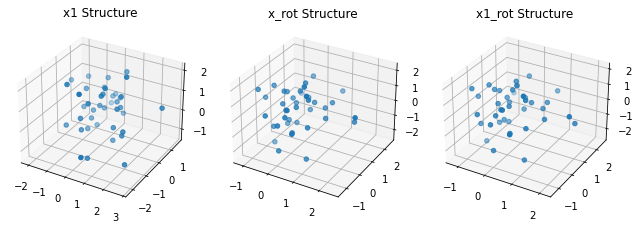

In [12]:
import matplotlib.pyplot as plt

def plot_3d_structures_in_row(coords_list, titles):
    """Visualize multiple 3D coordinates side by side using matplotlib."""
    n_plots = len(coords_list)
    fig = plt.figure(figsize=(n_plots*3, 3))
    
    for idx, (coords, title) in enumerate(zip(coords_list, titles)):
        ax = fig.add_subplot(1, n_plots, idx+1, projection='3d')
        coords_np = coords.detach().numpy()
        ax.scatter(coords_np[:, 0], coords_np[:, 1], coords_np[:, 2])
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# Reshape outputs for visualization
x1_reshaped = x1.reshape(batch_size, n_nodes, x_dim)
x_rot_reshaped = x_rot.reshape(batch_size, n_nodes, x_dim)
x1_rot_reshaped = x1_rot.reshape(batch_size, n_nodes, x_dim)

# Visualize the original and rotated structures for the first molecule in the batch in one row
coords_list = [x1_reshaped[0], x_rot_reshaped[0], x1_rot_reshaped[0]]
titles = ["x1 Structure", "x_rot Structure", "x1_rot Structure"]

plot_3d_structures_in_row(coords_list, titles)
